# BPR
Assume an inderlying recommender, parameterized by $\Theta$, that models, for each user $u \in U$, the relevance of all the items $i \in I$. Denote $x_{ui}$ the relevance score of item $i$ to user $u$. Then, $x_{uij}(\Theta) = x_{ui}(\Theta) - x_{uj}(\Theta)$ models how much user $u$ prefers item $i$ over $j$. Given a user $u$ and a pair of items $(i, j)$, the probability that the user $u$ will prefer item $i$ over $j$ can be modeled as

$$
    P(i >_u j | \Theta) = \sigma(x_{uij}(\Theta)),
$$

For notation facility, the conditionality on $\Theta$ can be ommited. Assume that the preferences of each user are independent, and that the preference relation over each pair of items for each user are also independent. Then, Considering $u^+$ to be the set of items which user $u$ provided positive feedback about, the likelihood of all the users preferences for the training data is

$$
    L(>|\Theta) = \prod_{u \in U} P(>_u | \Theta) = \prod_{u \in U} \prod_{i \in u^+} \prod_{j \notin u^+} P(i >_u j | \Theta) 
$$

To complete the Bayesian framework, it is assumed, a priori, that $\Theta \sim N(0, \lambda I)$, where $\lambda$ controls the model complexity. The posterior distribution of the underlying recommender parameters for some user $u$ is

$$
    P(\Theta | >_u) \propto P(>_u | \Theta) P(\Theta)
$$

The optimal $\Theta^*$ is then choosen to maximize the log-likelihood of the posteriori distribution for $\Theta$.

\begin{align}
    \Theta^* &= \arg_\Theta\max \log P(\Theta | >_u) \\
             &= \arg_\Theta\max \log P(>_u | \Theta) P(\Theta) \\
             &= \arg_\Theta\max \log \prod_{u \in U} \prod_{i \in u^+} \prod_{j \notin u^+} \sigma(x_{uij}) P(\Theta) \\
             &= \arg_\Theta\max \sum_{u \in U} \sum_{i \in u^+} \sum_{j \notin u^+} \log \sigma(x_{uij}) + \log P(\Theta) \\
             &= \arg_\Theta\max \sum_{u \in U} \sum_{i \in u^+} \sum_{j \notin u^+} \log \sigma(x_{uij}) - \lambda ||\Theta||^2
\end{align}

# Adaptive BPR (ABPR)
Now let $\rho_{ui}$ denote the uncertainty around $x_{ui}$ and assume $\rho_{uij}: \rho_{ui} \times \rho_{uj} \rightarrow R^+$ is the uncertainty around $x_{uij}$. Also, consider that $\Theta$ parameterizes both $x_{uij} and \rho_{uij}$. Then, the same probability can me modeled as

$$
    P(i >_u j | \Theta) = \sigma\left(\frac{x_{uij}}{\rho_{uij}}\right) 
$$

And following the same framework as BPR,

\begin{align}
    \Theta^* = \arg_\Theta\max \sum_{u \in U} \sum_{i \in u^+} \sum_{j \notin u^+} \log \sigma\left(\frac{x_{uij}}{\rho_{uij}}\right) - \lambda ||\Theta||^2
\end{align}

I call this adaptive BPR because it weights each instance according to the uncertainty around the pairwise relations.

# Gaussian pairwise ranking (GPR)
Although done implicitly, BPR assumes that $i >_u j | \Theta \sim Bern(\sigma(x_{uij}))$. This assumption allows such probabilities to be calculated. Another approach, would be to consider that the relevance scores $x_{ui}$ are normally distributed random variables, that is, $x_{ui}|\Theta \sim N(\mu_{ui}, \sigma^2_{ui})$. Therefore, $x_{uij} = x_{ui} - x_{uj}$ is a also normally distributed, whith mean $\mu_{ui} - \mu_{uj}$ and variance $\sigma^2_{ui} + \sigma^2_{uj}$. In this setup, the probability that the user $u$ will prefer item $i$ over $j$ can be written as

$$
    P(i >_u j | \Theta) = P(x_{uij} > 0 | \Theta) = P(x_{uji} \leq 0 | \Theta)
$$

As $x_{uji}$ is also normally distributed, we can explicitly calculate this probability

$$
    P(x_{uji} \leq 0 | \Theta) = P\left(\frac{x_{uji} - (\mu_{uj} - \mu_{ui})}{\sqrt{\sigma^2_{uj} + \sigma^2_{ui}}} \leq \frac{- (\mu_{uj} - \mu_{ui})}{\sqrt{\sigma^2_{uj} + \sigma^2_{ui}}} \Bigg| \Theta \right) = \Phi \left( \frac{\mu_{ui} - \mu_{uj}}{\sqrt{\sigma^2_{uj} + \sigma^2_{ui}}}\right)
$$

Where $\Phi$ is the standard gaussian distribution cumulative distribution function. Therefore, the optimal $\Theta$ can be choosen as

\begin{align}
    \Theta^* = \arg_\Theta\max \sum_{u \in U} \sum_{i \in u^+} \sum_{j \notin u^+} \log \Phi \left( \frac{\mu_{ui} - \mu_{uj}}{\sqrt{\sigma^2_{uj} + \sigma^2_{ui}}}\right) - \lambda ||\Theta||^2
\end{align}

# The Likelihood of $P(i >_u j)$ as a function of $x_{uij}$ for different values of $\rho_{uij}$

In [1]:
import torch
import math
from matplotlib import pyplot as plt

def adaptive_bpr(diff, unc):
    return torch.sigmoid(diff / unc)

def uncertain(diff, unc):
    return 0.5 * (1 + torch.erf((diff / torch.sqrt(2*unc**2))))

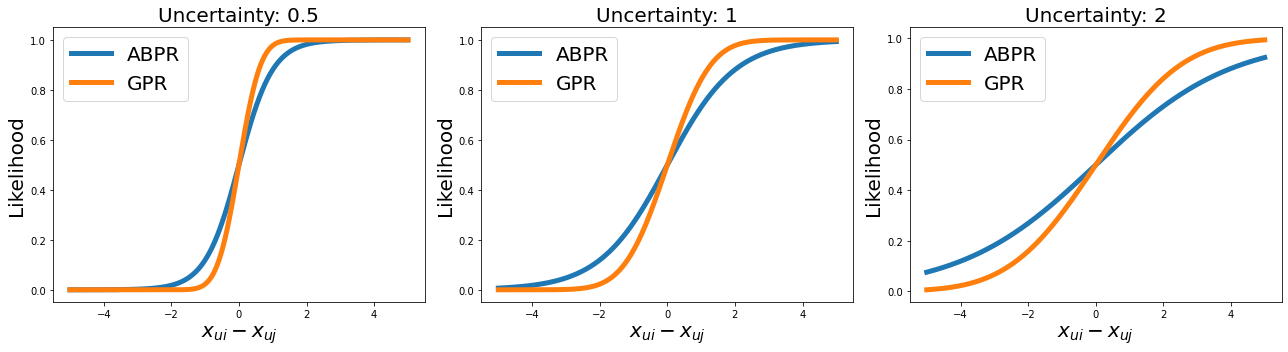

In [2]:
x = torch.linspace(-5, 5, 10000)
f, ax = plt.subplots(ncols=3, figsize=(18, 5))
for idx, uncertainty in enumerate([0.5, 1, 2]):
    ax[idx].plot(x, adaptive_bpr(x, uncertainty), label='ABPR', linewidth=5)
    ax[idx].plot(x, uncertain(x, torch.tensor(uncertainty)), label='GPR', linewidth=5)
    ax[idx].set_title('Uncertainty: {}'.format(uncertainty), fontsize=20)
    ax[idx].set_xlabel(r'$x_{ui} - x_{uj}$', fontsize=20)
    ax[idx].set_ylabel('Likelihood', fontsize=20)
    ax[idx].legend(fontsize=20)
f.tight_layout()

Notice that both formulations are similar. In practice, the GPR is a less smooth (rougher) version of the adaptive BPR.

# Problem: The log scale

First, this is how the log-likelihood of $P(i >_u j)$ for different values of $\rho_{uij}$ looks like,

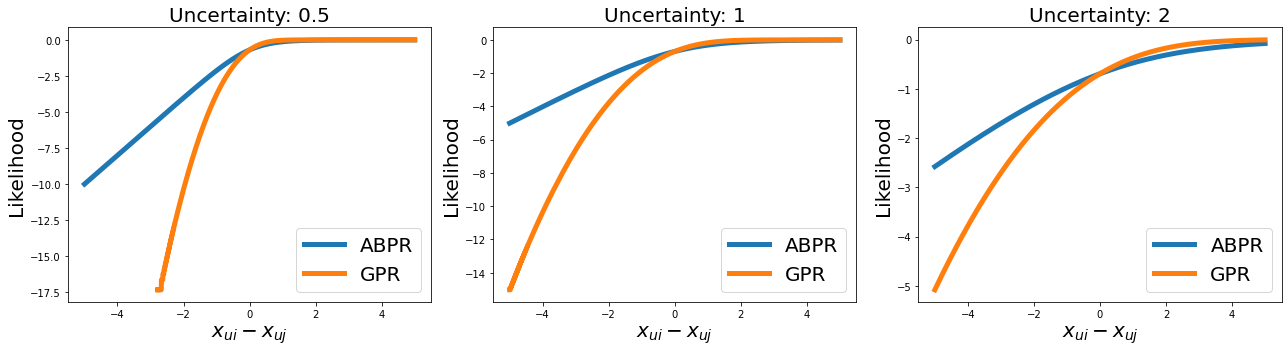

In [3]:
x = torch.linspace(-5, 5, 10000)
f, ax = plt.subplots(ncols=3, figsize=(18, 5))
for idx, uncertainty in enumerate([0.5, 1, 2]):
    ax[idx].plot(x, adaptive_bpr(x, uncertainty).log(), label='ABPR', linewidth=5)
    ax[idx].plot(x, uncertain(x, torch.tensor(uncertainty)).log(), label='GPR', linewidth=5)
    ax[idx].set_title('Uncertainty: {}'.format(uncertainty), fontsize=20)
    ax[idx].set_xlabel(r'$x_{ui} - x_{uj}$', fontsize=20)
    ax[idx].set_ylabel('Likelihood', fontsize=20)
    ax[idx].legend(fontsize=20)
f.tight_layout()

Notice that for $\rho_{uij} = 0.5$ and $x_{uij} < -3$ the log-likelihood is already intractable. The problem is that, if the term $\frac{x_{uij}}{\rho_{uij}}$ (in the case of ABPR) or $\frac{\mu_{ui} - \mu_{uj}}{\rho_{uij}}$ (for GPR), is too small, then $P(i >_u j)$ goes to 0 its logarithm goes to $-\infty$. At 8-bit precision, $\log P(i >_u j) \rightarrow -\infty$ for $\frac{x_{uij}}{\rho_{uij}} < -88.7$ for ABPR and $\frac{\mu_{ui} - \mu_{uj}}{\rho_{uij}\sqrt{2}} < -3.9$ for GPR, as seen in the following cell.

In [4]:
def abpr(x):
    return x.sigmoid()

def gpr(x):
    return (0.5 * (1 + torch.erf((x))))

for func in [abpr, gpr]:
    x = torch.tensor(-1)
    while True:
        x = x - 0.01
        y = func(x)
        if y.log() == -float('inf'):
            print('Lower bound for {}: {}, occurred at y = {}. \n'.format(func, x, y))
            break

Lower bound for <function abpr at 0x7ff6e3081670>: -88.73054504394531, occurred at y = 0.0. 

Lower bound for <function gpr at 0x7ff6e3081790>: -3.929997205734253, occurred at y = 0.0. 



The numerical instability for too small values is not the only problem regarding uncertainty in the loss scale. While maximizing the log-likelihood, the algorithm will give higher priority to incorrect classifications (negative > positive) then to already correct ones with small margin (when the positive relevace is just slightly higher than the negative). This does not happen is the normal (non-log) scale, as the following plot shows.

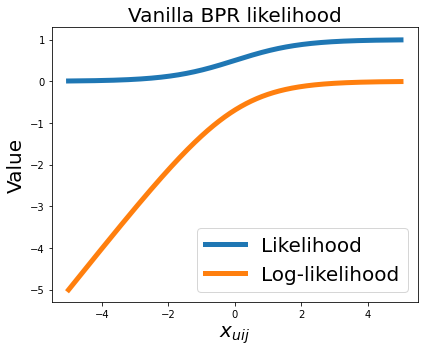

In [5]:
f, ax = plt.subplots(figsize=(6, 5))
x = torch.linspace(-5, 5, 10000)
y = adaptive_bpr(x, 1)
ax.plot(x, y, label='Likelihood', linewidth=5)
ax.plot(x, y.log(), label='Log-likelihood', linewidth=5)
ax.set_title('Vanilla BPR likelihood'.format(uncertainty), fontsize=20)
ax.set_xlabel(r'$x_{uij}$', fontsize=20)
ax.set_ylabel('Value', fontsize=20)
ax.legend(fontsize=20)
f.tight_layout()

Although this might be an advantage in terms of the pairwise ranking learning, it will lead the model to have poor uncertainty estimates for already correctly classified instances. Moreover, the set of recommendations for a user (top-K) consists of items that have been consider to be more relevant than other by the largest margins, meaning that the uncertainty estimates at top-K will be, most likely, very misleading.

In [6]:
import sys
sys.path.append('..')

from uncertain.models import ImplicitMF, UncertainMF, ImplicitGMF, UncertainGMF
from uncertain.loss import BPR, ABPR, GPR
from uncertain.datasets.movielens import get_movielens_dataset
from utils import train_test, uncertainty_distributions

ML = get_movielens_dataset(variant='1M')
ML.users, ML.items, ML.scores = ML[ML.scores >= 4]
delattr(ML, 'scores')
train, val, test = ML.split(test_percentage=0.1, validation_percentage=0.1, seed=0)
train, val, test

(<Implicit interactions (6041 users x 3707 items x 457818 interactions)>,
 <Implicit interactions (6041 users x 3707 items x 60213 interactions)>,
 <Implicit interactions (6041 users x 3707 items x 57250 interactions)>)

In [7]:
model = ImplicitMF(interactions=train, embedding_dim=10, lr=1e-3, weight_decay=0, loss = BPR(log_scale=False))
print(train_test(model, train, val, test, max_k=10))

#model = ImplicitMF(interactions=train, embedding_dim=10, lr=1e-3, weight_decay=0, loss = BPR(log_scale=True))
#print(train_test(model, train, val, test, max_k=10))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

{'Precision': tensor([0.1427, 0.1323, 0.1240, 0.1164, 0.1115, 0.1071, 0.1039, 0.1002, 0.0972,
        0.0946], dtype=torch.float64), 'Recall': tensor([0.0215, 0.0368, 0.0510, 0.0624, 0.0730, 0.0823, 0.0933, 0.1027, 0.1125,
        0.1205]), 'NDCG': tensor([0.1427, 0.1629, 0.1890, 0.2118, 0.2343, 0.2533, 0.2713, 0.2858, 0.3003,
        0.3136], dtype=torch.float64), 'AUC': 0.929730995443344}


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | user_gammas     | Embedding | 6.0 K 
3 | item_gammas     | Embedding | 3.7 K 
4 | unc_activation  | Softplus  | 0     
----------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.429     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | user_gammas     | Embedding | 6.0 K 
3 | item_gammas     | Embedding | 3.7 K 
4 | unc_activation  | Softplus  | 0     
----------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.429     Total estimated model params size (MB)


{'Precision': tensor([0.1476, 0.1337, 0.1261, 0.1175, 0.1118, 0.1077, 0.1033, 0.0999, 0.0972,
        0.0944], dtype=torch.float64), 'Recall': tensor([0.0219, 0.0373, 0.0516, 0.0638, 0.0755, 0.0853, 0.0943, 0.1036, 0.1122,
        0.1218]), 'NDCG': tensor([0.1476, 0.1661, 0.1921, 0.2148, 0.2363, 0.2558, 0.2724, 0.2881, 0.3025,
        0.3162], dtype=torch.float64), 'RRI': tensor([-0.0261, -0.0792, -0.1272, -0.1642, -0.1981, -0.2244, -0.2424, -0.2605,
        -0.2779]), 'AUC': 0.929697703795931}
Figure(432x288)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | user_gammas     | Embedding | 6.0 K 
3 | item_gammas     | Embedding | 3.7 K 
4 | unc_activation  | Softplus  | 0     
----------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.429     Total estimated model params size (MB)


{'Precision': tensor([0.1433, 0.1330, 0.1264, 0.1194, 0.1151, 0.1114, 0.1080, 0.1041, 0.1012,
        0.0980], dtype=torch.float64), 'Recall': tensor([0.0206, 0.0369, 0.0522, 0.0650, 0.0796, 0.0921, 0.1043, 0.1140, 0.1243,
        0.1340]), 'NDCG': tensor([0.1433, 0.1632, 0.1905, 0.2153, 0.2398, 0.2610, 0.2802, 0.2958, 0.3114,
        0.3245], dtype=torch.float64), 'RRI': tensor([ 0.0033, -0.0291, -0.0577, -0.0688, -0.0835, -0.1023, -0.1191, -0.1317,
        -0.1454]), 'AUC': 0.935300636610744}
Figure(432x288)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | user_gammas     | Embedding | 6.0 K 
3 | item_gammas     | Embedding | 3.7 K 
4 | unc_activation  | Softplus  | 0     
----------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.429     Total estimated model params size (MB)


{'Precision': tensor([0.1483, 0.1339, 0.1258, 0.1210, 0.1160, 0.1109, 0.1076, 0.1047, 0.1014,
        0.0987], dtype=torch.float64), 'Recall': tensor([0.0220, 0.0378, 0.0514, 0.0643, 0.0765, 0.0870, 0.0978, 0.1085, 0.1182,
        0.1278]), 'NDCG': tensor([0.1483, 0.1646, 0.1903, 0.2168, 0.2392, 0.2581, 0.2766, 0.2938, 0.3084,
        0.3224], dtype=torch.float64), 'RRI': tensor([-0.0632, -0.1607, -0.2578, -0.3428, -0.4138, -0.4796, -0.5355, -0.5803,
        -0.6265]), 'AUC': 0.9325456699542419}
Figure(432x288)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

{'Precision': tensor([0.1430, 0.1365, 0.1292, 0.1221, 0.1171, 0.1132, 0.1094, 0.1061, 0.1029,
        0.1006], dtype=torch.float64), 'Recall': tensor([0.0221, 0.0406, 0.0557, 0.0686, 0.0809, 0.0934, 0.1048, 0.1157, 0.1250,
        0.1348]), 'NDCG': tensor([0.1430, 0.1660, 0.1936, 0.2179, 0.2417, 0.2633, 0.2818, 0.2988, 0.3141,
        0.3290], dtype=torch.float64), 'RRI': tensor([-0.0548, -0.1357, -0.2002, -0.2531, -0.2961, -0.3401, -0.3758, -0.4096,
        -0.4366]), 'AUC': 0.9351826950404619}
Figure(432x288)


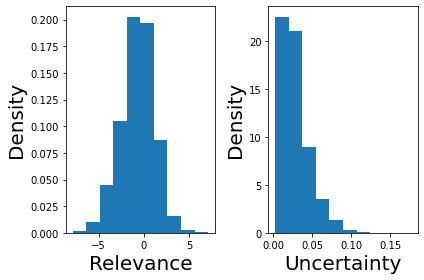

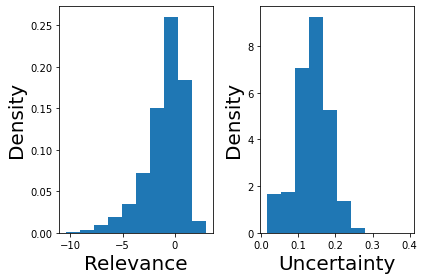

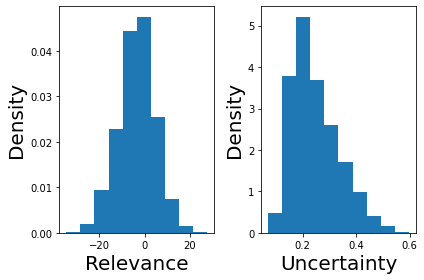

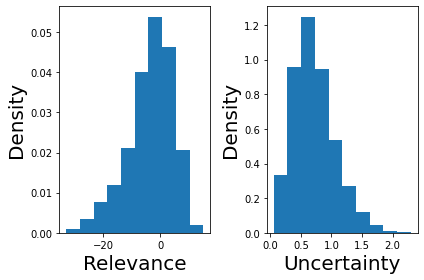

In [8]:
model2 = UncertainMF(interactions=train, embedding_dim=10, lr=1e-3, weight_decay=0, loss=ABPR(log_scale=False), compose=lambda x,y: x+y, init_value=0)
print(train_test(model2, train, val, test, max_k=10))
print(uncertainty_distributions(model2))

model2 = UncertainMF(interactions=train, embedding_dim=10, lr=1e-3, weight_decay=0, loss=ABPR(log_scale=True), compose=lambda x,y: x+y, init_value=0)
print(train_test(model2, train, val, test, max_k=10))
print(uncertainty_distributions(model2))

model2 = UncertainMF(interactions=train, embedding_dim=10, lr=1e-3, weight_decay=0, loss=ABPR(log_scale=False), compose=lambda x,y: x+y, init_value=0)
print(train_test(model2, train, val, test, max_k=10, pretrain=model))
print(uncertainty_distributions(model2))

model2 = UncertainMF(interactions=train, embedding_dim=10, lr=1e-3, weight_decay=0, loss=ABPR(log_scale=True), compose=lambda x,y: x+y, init_value=0)
print(train_test(model2, train, val, test, max_k=10, pretrain=model))
print(uncertainty_distributions(model2))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | user_gammas     | Embedding | 6.0 K 
3 | item_gammas     | Embedding | 3.7 K 
4 | unc_activation  | Softplus  | 0     
----------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.429     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | user_gammas     | Embedding | 6.0 K 
3 | item_gammas     | Embedding | 3.7 K 
4 | unc_activation  | Softplus  | 0     
----------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.429     Total estimated model params size (MB)


{'Precision': tensor([0.1430, 0.1302, 0.1196, 0.1140, 0.1081, 0.1053, 0.1025, 0.0996, 0.0969,
        0.0945], dtype=torch.float64), 'Recall': tensor([0.0206, 0.0355, 0.0476, 0.0599, 0.0711, 0.0816, 0.0919, 0.1015, 0.1103,
        0.1194]), 'NDCG': tensor([0.1430, 0.1594, 0.1812, 0.2059, 0.2263, 0.2470, 0.2658, 0.2818, 0.2963,
        0.3103], dtype=torch.float64), 'RRI': tensor([ 0.0048, -0.0256, -0.0784, -0.1204, -0.1572, -0.1945, -0.2307, -0.2695,
        -0.2987]), 'AUC': 0.9288141228812249}
Figure(432x288)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | user_gammas     | Embedding | 6.0 K 
3 | item_gammas     | Embedding | 3.7 K 
4 | unc_activation  | Softplus  | 0     
----------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.429     Total estimated model params size (MB)


{'Precision': tensor([0.1153, 0.1064, 0.1011, 0.0964, 0.0923, 0.0891, 0.0864, 0.0834, 0.0807,
        0.0789], dtype=torch.float64), 'Recall': tensor([0.0166, 0.0291, 0.0398, 0.0486, 0.0576, 0.0661, 0.0748, 0.0827, 0.0892,
        0.0967]), 'NDCG': tensor([0.1153, 0.1338, 0.1584, 0.1801, 0.1989, 0.2162, 0.2324, 0.2460, 0.2580,
        0.2702], dtype=torch.float64), 'RRI': tensor([0.1432, 0.2664, 0.3097, 0.3507, 0.3788, 0.3975, 0.4067, 0.4172, 0.4278]), 'AUC': 0.9053447588929708}
Figure(432x288)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | user_gammas     | Embedding | 6.0 K 
3 | item_gammas     | Embedding | 3.7 K 
4 | unc_activation  | Softplus  | 0     
----------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.429     Total estimated model params size (MB)


{'Precision': tensor([0.1458, 0.1328, 0.1274, 0.1199, 0.1153, 0.1121, 0.1078, 0.1044, 0.1006,
        0.0983], dtype=torch.float64), 'Recall': tensor([0.0217, 0.0381, 0.0519, 0.0638, 0.0766, 0.0888, 0.0992, 0.1093, 0.1182,
        0.1277]), 'NDCG': tensor([0.1458, 0.1631, 0.1920, 0.2154, 0.2384, 0.2602, 0.2778, 0.2946, 0.3080,
        0.3223], dtype=torch.float64), 'RRI': tensor([-0.0256, -0.1103, -0.1940, -0.2666, -0.3293, -0.3860, -0.4351, -0.4886,
        -0.5306]), 'AUC': 0.9321962857558401}
Figure(432x288)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

{'Precision': tensor([0.0015, 0.0009, 0.0007, 0.0006, 0.0005, 0.0005, 0.0005, 0.0006, 0.0005,
        0.0006], dtype=torch.float64), 'Recall': tensor([7.3245e-05, 8.6301e-05, 9.3585e-05, 9.8464e-05, 1.0577e-04, 1.0884e-04,
        1.3665e-04, 1.6249e-04, 1.7536e-04, 2.1968e-04]), 'NDCG': tensor([0.0015, 0.0017, 0.0019, 0.0019, 0.0021, 0.0021, 0.0025, 0.0027, 0.0028,
        0.0031], dtype=torch.float64), 'RRI': tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'AUC': 0.3553281947990219}
Figure(432x288)


/home/vcoscrato/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6710: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/vcoscrato/.local/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6711: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


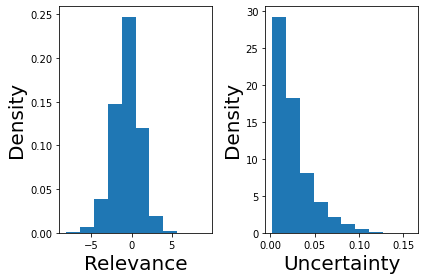

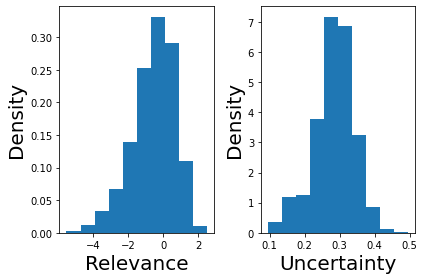

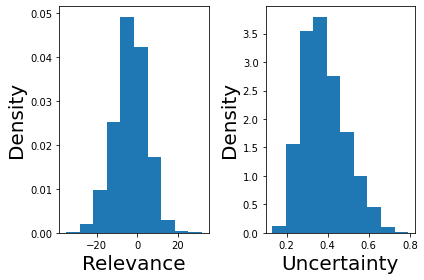

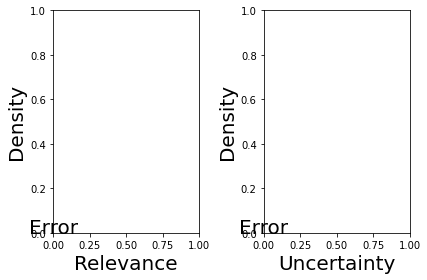

In [9]:
model2 = UncertainMF(interactions=train, embedding_dim=10, lr=1e-3, weight_decay=0, loss=GPR(log_scale=False), compose=lambda x,y: x+y, init_value=0)
print(train_test(model2, train, val, test, max_k=10))
print(uncertainty_distributions(model2))

model2 = UncertainMF(interactions=train, embedding_dim=10, lr=1e-3, weight_decay=0, loss=GPR(log_scale=True), compose=lambda x,y: x+y, init_value=0)
print(train_test(model2, train, val, test, max_k=10))
print(uncertainty_distributions(model2))

model2 = UncertainMF(interactions=train, embedding_dim=10, lr=1e-3, weight_decay=0, loss=GPR(log_scale=False), compose=lambda x,y: x+y, init_value=0)
print(train_test(model2, train, val, test, max_k=10, pretrain=model))
print(uncertainty_distributions(model2))

model2 = UncertainMF(interactions=train, embedding_dim=10, lr=1e-3, weight_decay=0, loss=GPR(log_scale=True), compose=lambda x,y: x+y, init_value=0)
print(train_test(model2, train, val, test, max_k=10, pretrain=model))
print(uncertainty_distributions(model2))

In [10]:
model = ImplicitGMF(interactions=train, embedding_dim=10, lr=1e-3, weight_decay=0, loss = BPR(log_scale=False))
print(train_test(model, train, val, test, max_k=10))

#model = ImplicitGMF(interactions=train, embedding_dim=10, lr=1e-3, weight_decay=0, loss = BPR(log_scale=True))
#print(train_test(model, train, val, test, max_k=10))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | linear          | Linear    | 10    
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

{'Precision': tensor([0.1367, 0.1282, 0.1210, 0.1146, 0.1104, 0.1069, 0.1040, 0.1014, 0.0986,
        0.0961], dtype=torch.float64), 'Recall': tensor([0.0200, 0.0357, 0.0492, 0.0608, 0.0723, 0.0835, 0.0944, 0.1060, 0.1156,
        0.1249]), 'NDCG': tensor([0.1367, 0.1571, 0.1831, 0.2062, 0.2286, 0.2489, 0.2679, 0.2857, 0.3005,
        0.3144], dtype=torch.float64), 'AUC': 0.9306727041704131}


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | linear          | Linear    | 10    
3 | unc             | Linear    | 10    
4 | unc_activation  | Softplus  | 0     
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | linear          | Linear    | 10    
3 | unc             | Linear    | 10    
4 | unc_activation  | Softplus  | 0     
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


{'Precision': tensor([0.0946, 0.0858, 0.0820, 0.0801, 0.0788, 0.0767, 0.0747, 0.0731, 0.0711,
        0.0698], dtype=torch.float64), 'Recall': tensor([0.0139, 0.0232, 0.0323, 0.0420, 0.0504, 0.0591, 0.0670, 0.0743, 0.0810,
        0.0873]), 'NDCG': tensor([0.0946, 0.1120, 0.1333, 0.1550, 0.1744, 0.1910, 0.2059, 0.2195, 0.2312,
        0.2429], dtype=torch.float64), 'RRI': tensor([0.2478, 0.5060, 0.6673, 0.7761, 0.8372, 0.8733, 0.8884, 0.8918, 0.8905]), 'AUC': 0.9071112916175913}
Figure(432x288)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | linear          | Linear    | 10    
3 | unc             | Linear    | 10    
4 | unc_activation  | Softplus  | 0     
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


{'Precision': tensor([0.1455, 0.1330, 0.1242, 0.1170, 0.1125, 0.1091, 0.1058, 0.1029, 0.1001,
        0.0970], dtype=torch.float64), 'Recall': tensor([0.0225, 0.0376, 0.0513, 0.0637, 0.0759, 0.0884, 0.1000, 0.1098, 0.1197,
        0.1277]), 'NDCG': tensor([0.1455, 0.1636, 0.1882, 0.2115, 0.2346, 0.2561, 0.2749, 0.2920, 0.3074,
        0.3204], dtype=torch.float64), 'RRI': tensor([-0.2168, -0.5075, -0.7169, -0.8759, -1.0097, -1.1239, -1.2203, -1.3062,
        -1.3819]), 'AUC': 0.9316319340704861}
Figure(432x288)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | linear          | Linear    | 10    
3 | unc             | Linear    | 10    
4 | unc_activation  | Softplus  | 0     
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


{'Precision': tensor([0.1384, 0.1276, 0.1225, 0.1163, 0.1125, 0.1083, 0.1056, 0.1018, 0.0997,
        0.0967], dtype=torch.float64), 'Recall': tensor([0.0205, 0.0359, 0.0510, 0.0634, 0.0762, 0.0866, 0.0988, 0.1085, 0.1184,
        0.1276]), 'NDCG': tensor([0.1384, 0.1566, 0.1840, 0.2086, 0.2323, 0.2524, 0.2725, 0.2877, 0.3038,
        0.3171], dtype=torch.float64), 'RRI': tensor([0.2719, 0.6186, 0.8455, 1.0022, 1.1239, 1.2225, 1.3027, 1.3715, 1.4273]), 'AUC': 0.9307757299237381}
Figure(432x288)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

{'Precision': tensor([0.1357, 0.1265, 0.1213, 0.1156, 0.1125, 0.1090, 0.1058, 0.1019, 0.0986,
        0.0960], dtype=torch.float64), 'Recall': tensor([0.0196, 0.0351, 0.0486, 0.0612, 0.0739, 0.0859, 0.0975, 0.1068, 0.1153,
        0.1240]), 'NDCG': tensor([0.1357, 0.1546, 0.1820, 0.2059, 0.2305, 0.2515, 0.2703, 0.2856, 0.2994,
        0.3131], dtype=torch.float64), 'RRI': tensor([-0.2171, -0.5213, -0.7504, -0.9232, -1.0648, -1.1836, -1.2868, -1.3770,
        -1.4590]), 'AUC': 0.9304125833415762}
Figure(432x288)


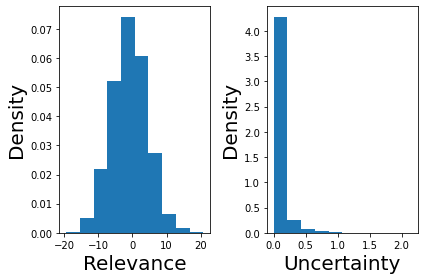

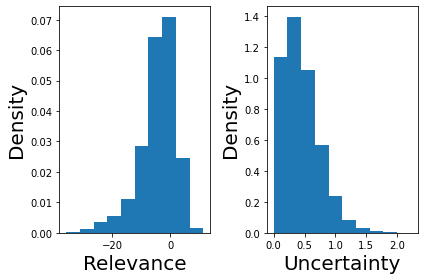

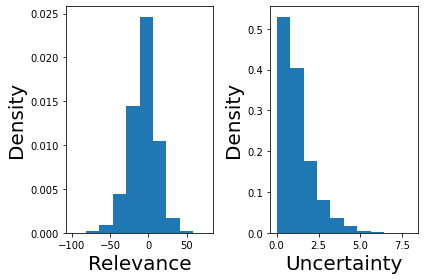

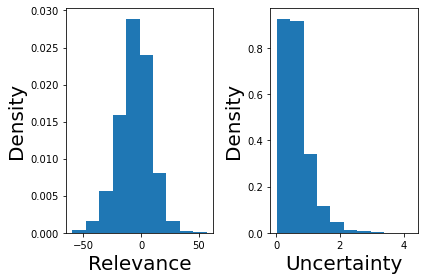

In [11]:
model2 = UncertainGMF(interactions=train, embedding_dim=10, lr=1e-3, weight_decay=0, loss=ABPR(log_scale=False))
print(train_test(model2, train, val, test, max_k=10))
print(uncertainty_distributions(model2))

model2 = UncertainGMF(interactions=train, embedding_dim=10, lr=1e-3, weight_decay=0, loss=ABPR(log_scale=True))
print(train_test(model2, train, val, test, max_k=10))
print(uncertainty_distributions(model2))

model2 = UncertainGMF(interactions=train, embedding_dim=10, lr=1e-3, weight_decay=0, loss=ABPR(log_scale=False))
print(train_test(model2, train, val, test, max_k=10, pretrain=model))
print(uncertainty_distributions(model2))

model2 = UncertainGMF(interactions=train, embedding_dim=10, lr=1e-3, weight_decay=0, loss=ABPR(log_scale=True))
print(train_test(model2, train, val, test, max_k=10, pretrain=model))
print(uncertainty_distributions(model2))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | linear          | Linear    | 10    
3 | unc             | Linear    | 10    
4 | unc_activation  | Softplus  | 0     
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | linear          | Linear    | 10    
3 | unc             | Linear    | 10    
4 | unc_activation  | Softplus  | 0     
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


{'Precision': tensor([0.1191, 0.1088, 0.1004, 0.0945, 0.0892, 0.0858, 0.0826, 0.0805, 0.0790,
        0.0767], dtype=torch.float64), 'Recall': tensor([0.0167, 0.0293, 0.0389, 0.0488, 0.0569, 0.0656, 0.0732, 0.0812, 0.0892,
        0.0961]), 'NDCG': tensor([0.1191, 0.1385, 0.1607, 0.1823, 0.2003, 0.2175, 0.2319, 0.2463, 0.2601,
        0.2713], dtype=torch.float64), 'RRI': tensor([0.2847, 0.6375, 0.8095, 0.8953, 0.9475, 0.9775, 0.9946, 1.0032, 1.0109]), 'AUC': 0.9208037538588779}
Figure(432x288)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | linear          | Linear    | 10    
3 | unc             | Linear    | 10    
4 | unc_activation  | Softplus  | 0     
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


{'Precision': tensor([0.1032, 0.1002, 0.0957, 0.0936, 0.0906, 0.0879, 0.0852, 0.0818, 0.0797,
        0.0778], dtype=torch.float64), 'Recall': tensor([0.0145, 0.0261, 0.0372, 0.0481, 0.0573, 0.0666, 0.0746, 0.0814, 0.0888,
        0.0956]), 'NDCG': tensor([0.1032, 0.1257, 0.1484, 0.1723, 0.1924, 0.2100, 0.2258, 0.2380, 0.2503,
        0.2624], dtype=torch.float64), 'RRI': tensor([-0.2237, -0.5198, -0.7193, -0.8736, -1.0004, -1.1024, -1.1862, -1.2633,
        -1.3286]), 'AUC': 0.907504311808955}
Figure(432x288)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 37.1 K
2 | linear          | Linear    | 10    
3 | unc             | Linear    | 10    
4 | unc_activation  | Softplus  | 0     
----------------------------------------------
97.5 K    Trainable params
0         Non-trainable params
97.5 K    Total params
0.390     Total estimated model params size (MB)


{'Precision': tensor([0.1400, 0.1267, 0.1211, 0.1154, 0.1118, 0.1091, 0.1059, 0.1024, 0.0995,
        0.0964], dtype=torch.float64), 'Recall': tensor([0.0200, 0.0349, 0.0497, 0.0615, 0.0745, 0.0873, 0.0983, 0.1078, 0.1164,
        0.1243]), 'NDCG': tensor([0.1400, 0.1560, 0.1831, 0.2079, 0.2319, 0.2543, 0.2729, 0.2887, 0.3039,
        0.3167], dtype=torch.float64), 'RRI': tensor([0.2392, 0.5790, 0.8010, 0.9586, 1.0746, 1.1628, 1.2354, 1.2971, 1.3468]), 'AUC': 0.9305520065636003}
Figure(432x288)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

{'Precision': tensor([0.0015, 0.0009, 0.0007, 0.0006, 0.0005, 0.0005, 0.0005, 0.0006, 0.0005,
        0.0006], dtype=torch.float64), 'Recall': tensor([7.3245e-05, 8.6301e-05, 9.3585e-05, 9.8464e-05, 1.0577e-04, 1.0884e-04,
        1.3665e-04, 1.6249e-04, 1.7536e-04, 2.1968e-04]), 'NDCG': tensor([0.0015, 0.0017, 0.0019, 0.0019, 0.0021, 0.0021, 0.0025, 0.0027, 0.0028,
        0.0031], dtype=torch.float64), 'RRI': tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan]), 'AUC': 0.3553281947990219}
Figure(432x288)


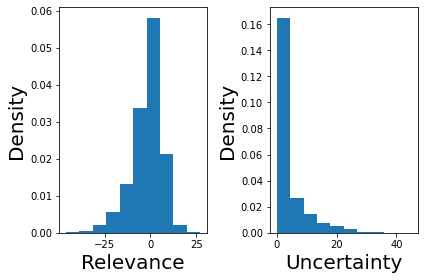

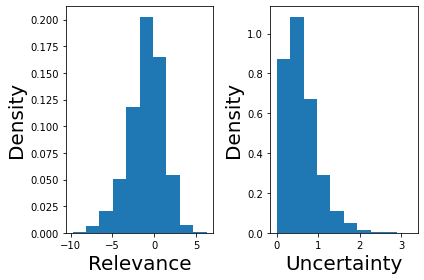

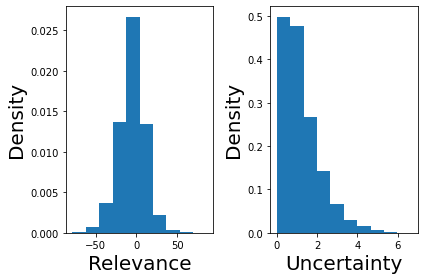

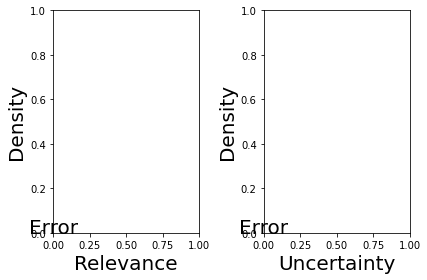

In [12]:
model2 = UncertainGMF(interactions=train, embedding_dim=10, lr=1e-3, weight_decay=0, loss=GPR(log_scale=False))
print(train_test(model2, train, val, test, max_k=10))
print(uncertainty_distributions(model2))

model2 = UncertainGMF(interactions=train, embedding_dim=10, lr=1e-3, weight_decay=0, loss=GPR(log_scale=True))
print(train_test(model2, train, val, test, max_k=10))
print(uncertainty_distributions(model2))

model2 = UncertainGMF(interactions=train, embedding_dim=10, lr=1e-3, weight_decay=0, loss=GPR(log_scale=False))
print(train_test(model2, train, val, test, max_k=10, pretrain=model))
print(uncertainty_distributions(model2))

model2 = UncertainGMF(interactions=train, embedding_dim=10, lr=1e-3, weight_decay=0, loss=GPR(log_scale=True))
print(train_test(model2, train, val, test, max_k=10, pretrain=model))
print(uncertainty_distributions(model2))